In [3]:
import sys
sys.path.append('src')

from Panakos import Panakos
import scipy.stats as stats
import collections
import math
import numpy as np
import matplotlib.pyplot as plt
from MRAC import MRAC
from ElasticSketch import ElasticSketch
from cocoSketch import CocoSketch
import pandas as pd
import bisect
from SpaceSaving import SpaceSaving
from cocoSketch import CocoSketch
from githubCountMin import CountMinSketch
from FCMSketch import FCMSketch
import random
from scipy.stats import entropy
from FCMSketch import FCMSketch
PanakosComponentsSpaceRatio = [0.15, 0.35, 0.5]

In [9]:
def max_quantile_diff(q1, q2):
    i = 0
    result = 0
    while i<len(q1) and i <len(q2):
        result = max(result, abs(q1[i] - q2[i]))
        i+=1
    while i<len(q1):
        result = max(result, abs(q1[i] - q2[-1]))
        i+=1
    while i<len(q2):
        result = max(result, abs(q1[-1] - q2[i]))
        i+=1
    return result


def ARE_freq_diff(true_q, estimated_q):
    prevPhi = 0
    ans = []
    for freq, phi in enumerate(true_q):
        if freq != 0 and prevPhi != phi: # query only once for each phi
            prevPhi = phi
            estimated_freq = bisect.bisect_left(estimated_q, phi) - 1
            ans.append( abs(freq - estimated_freq) / freq)
    return 1.0 * sum(ans) / len(ans)



def precision(trueHH, estimatedHH):
    TP, FP = 0.0, 0.0
    for item in estimatedHH:
        if item in trueHH:
            TP += 1
        else:
            FP += 1
    return 1.0*TP/(TP+FP)

def recall(trueHH, estimatedHH):
    TP, FN = 0.0, 0.0
    for item in trueHH:
        if item in estimatedHH:
            TP += 1
        else:
            FN += 1
    return 1.0*TP/(TP+FN)

In [10]:
def intersection(arr1, arr2):
    return set(arr1).intersection(arr2)

In [4]:
zipf_1 = []
for line in open('data/zipf1.0.txt', 'r'):
    for num in line.split(','):
        if len(zipf_1) == 10**6:
            break
        zipf_1.append(int(num))
print(zipf_1[:10])
print(zipf_1[-1])

[18, 6, 696, 54801, 2, 1, 953, 1907, 14378, 18944]
10


In [12]:
def quantileErrorVsSpace(metrics = 0, streamType = "zipf", skewness = 1.5, streamLength = 10**5, dataset = []):
    P_errors = []
    M_errors = []
    E_errors = []
    F_errors = []

    P_T = 17
    spaces =[2**11*4/1024, 2**12*4/1024, 2**13*4/1024, 2**14*4/1024, 2**15*4/1024]
    insertions = dataset[:streamLength]


    for index, s in enumerate(spaces):
        s *= 1024 / 4 # conver to number of counters
        SS_eps = 1.0 / (s * PanakosComponentsSpaceRatio[0])
        bitlen = math.ceil( PanakosComponentsSpaceRatio[1] * s * 32 / 2)
        # CM uses 2 rows
        CM_eps = 2.0 / ((PanakosComponentsSpaceRatio[2] * s) * (32 / math.log2(P_T-2)))  

        P = Panakos(bitlen, SS_eps, CM_eps, P_T)
        M = MRAC(P.space())
        # in the paper it says heavy part is 25% (150/600) and lightpart is 75% (560/600) of total memory
        # in HeavyPart buket contains 8 pairs
        E = ElasticSketch(math.ceil(0.25*P.space()/8), math.ceil(0.75*P.space() * 4)) 
        
        # FCMx is the number of entires in the last layer for FCM
        # FCM uses 8 bit, 16bit and 32bit with branching factor of 8
        FCMx = int(P.space()*32.0 / (32 + 16 * 8 + 8 * 64))
        F = FCMSketch([[64*FCMx, 8],[8*FCMx, 16],[FCMx, 32]])
            
        for i in insertions:
            P.update(i)
            M.insert(i)
            E.insert(i)
            F.update(i)

        table = collections.Counter(insertions)
        max_freq = max(table.values())
        true_vector = [0 for i in range(max_freq+1)]
        q_vector = []
        for key, val in table.items():
            true_vector[val] += 1
        prev = 0
        for count in true_vector:
            assert count >= 0
            prev += count
            q_vector.append(prev/sum(true_vector))


        P_quantile = P.cdf()
        M_quantile = M.cdf()
        E_quantile = E.cdf()
        F_quantile = F.cdf()
            

        P_error, M_error, E_error, F_error = 0, 0, 0, 0
        if metrics == 0:
            P_error = max_quantile_diff(q_vector, P_quantile)
            M_error = max_quantile_diff(q_vector, M_quantile)
            E_error = max_quantile_diff(q_vector, E_quantile)
            F_error = max_quantile_diff(q_vector, F_quantile)
        elif metrics == 1:
            P_error = ARE_freq_diff(q_vector, P_quantile)
            M_error = ARE_freq_diff(q_vector, M_quantile)
            E_error = ARE_freq_diff(q_vector, E_quantile)
            F_error = ARE_freq_diff(q_vector, F_quantile)
        else:
            assert 0
        P_errors.append(P_error)
        M_errors.append(M_error)
        E_errors.append(E_error)
        F_errors.append(F_error)
                
    print(spaces)
    print("P: ", P_errors)
    print("MRAC: ", M_errors)
    print("Elastic: ", E_errors)
    print("FCM: ", F_errors)
    
    if streamType == 'zipf':
        plt.title("Zipf("+str(a)+")", fontsize=15)
    elif streamType == "CAIDA":
        plt.title("CAIDA", fontsize=15)
    elif streamType == "sensor":
        plt.title("SensorScope", fontsize=15)
    else:
        plt.title("E-Shop", fontsize=15)
        
    plt.xlabel('Space(KB)', fontsize=13)
    
    if metrics == 0:
        plt.ylabel('Maximum Quantile Error', fontsize=13)
    elif metrics == 1:
        plt.ylabel('ARE', fontsize=13)
    else:
        assert 0
    

    plt.yscale('log',basey=10)
    plt.xscale('log',basex=2)

    plt.plot(spaces, P_errors, 'bv--', label='Panakos')
    plt.plot(spaces, M_errors, 'kd--', label='MRAC')
    plt.plot(spaces, E_errors, 'rp--', label='Elastic')
    plt.plot(spaces, F_errors, 'yo--', label='FCM')
    # color = '#FFA500'

    plt.legend(prop={'size': 10})
    
    

[8.0, 16.0, 32.0, 64.0, 128.0]
P:  [0.5800891561433889, 0.33705319071225587, 0.19556682089545407, 0.10838232047203844, 0.05647192970550974]
MRAC:  [0.8986813007269501, 0.7280670759862881, 0.45911445038328785, 0.2784234576892172, 0.1506623812230028]
Elastic:  [0.8913713778213898, 0.9396172638824662, 0.8287107202982996, 0.629709096073201, 0.3111995456630399]
FCM:  [0.5690445580576902, 0.3464056881400833, 0.1963602134355279, 0.10868594336443149, 0.0574598234239444]


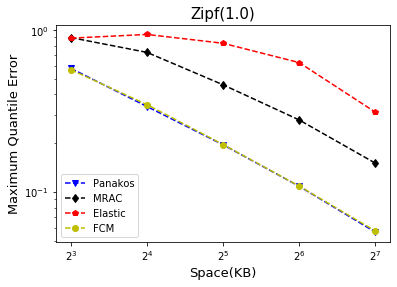

In [18]:
quantileErrorVsSpace(0, "zipf", 1.0, 10**5, zipf_1)

[8.0, 16.0, 32.0, 64.0, 128.0]
P:  [0.195081108422831, 0.07094112955344196, 0.04321176845731284, 0.009646777226371219, 0.011696960992972509]
MRAC:  [7.264333388081466, 3.2407241368864117, 1.3146832223980243, 0.5183983864598201, 0.22215057680380756]
Elastic:  [39.88409776029983, 31.709998931829414, 19.92422073675345, 8.209190359578407, 2.260218662854836]
FCM:  [1.9709376726508385, 0.7679491062170557, 0.308915614043072, 0.13817152598209512, 0.06884716656167898]


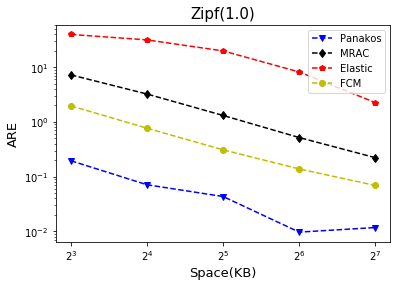

In [19]:
quantileErrorVsSpace(1, "zipf", 1.0, 10**5, zipf_1)

In [24]:
def identifyTailItemsVsSpace(phiThreshold = 0.99, streamType = "zipf", streamLength = 10**5, dataset = []):
    P_errors = []
    E_errors = []
    F_errors = []

    P_T = 17
    a = 1.0
    spaces = [2**11*4/1024, 2**12*4/1024, 2**13*4/1024, 2**14*4/1024, 2**15*4/1024]
    
    insertions = dataset[:streamLength]

    for index, s in enumerate(spaces):
        s *= 1024 / 4 # conver to number of counters
        SS_eps = 1.0 / (s * PanakosComponentsSpaceRatio[0])
        bitlen = math.ceil( PanakosComponentsSpaceRatio[1] * s * 32 / 2)
        # CM uses 2 rows
        CM_eps = 2.0 / ((PanakosComponentsSpaceRatio[2] * s) * (32 / math.log2(P_T-2)))       
        P = Panakos(bitlen, SS_eps, CM_eps, P_T)
        
        # in the paper it says heavy part is 25% and lightpart is 75% of total memory
        # in HeavyPart buket contains 8 pairs
        E = ElasticSketch(math.ceil(0.25*P.space()/8), math.ceil(0.75*P.space() * 4)) 
        
        FCMx = int(P.space()*32.0 / (32 + 16 * 8 + 8 * 64))
        F = FCMSketch([[64*FCMx, 8],[8*FCMx, 16],[FCMx, 32]])
            
        for i in insertions:
            P.update(i)
            F.update(i)
            E.insert(i)
        
        # Tail Contributors
        P_TC = set()
        E_TC = set() 
        F_TC = set() 
        trueTC = set()
            
        table = collections.Counter(insertions)
        max_freq = max(table.values())
        true_vector = [0 for i in range(max_freq+1)]
        q_vector = []
        for key, val in table.items():
            true_vector[val] += 1
        prev = 0
        for count in true_vector:
            assert count >= 0
            prev += count
            q_vector.append(prev/sum(true_vector))
        # identify the frequency associate with phiThreshold
        freqThreshold = bisect.bisect_left(q_vector, phiThreshold)
            
        P_quantile = P.cdf()
        P_freqThreshold = bisect.bisect_left(P_quantile, phiThreshold)
            
            
        E_quantile = E.cdf()
        E_freqThreshold = bisect.bisect_left(E_quantile, phiThreshold)
            
        F_quantile = F.cdf()
        F_freqThreshold = bisect.bisect_left(F_quantile, phiThreshold)
            
        for key, val in table.items():
            if val >= freqThreshold:
                trueTC.add(key)
            if P.query(key) >= P_freqThreshold:
                P_TC.add(key)
            if E.query(key) >= E_freqThreshold:
                E_TC.add(key)
            if F.query(key) >= F_freqThreshold:
                F_TC.add(key)
            
        P_error, E_error, F_error = 0, 0, 0

        P_recall = recall(trueTC, P_TC)
        P_precision = precision(trueTC, P_TC)
        P_error = 2.0*P_recall*P_precision / (P_precision + P_recall)
            
        E_recall = recall(trueTC, E_TC)
        E_precision = precision(trueTC, E_TC)
        E_error = 2.0*E_recall*E_precision / (E_precision + E_recall)
                
        F_recall = recall(trueTC, F_TC)
        F_precision = precision(trueTC, F_TC)
        F_error = 2.0*F_recall*F_precision / (F_precision + F_recall)
                

        P_errors.append(P_error)
        E_errors.append(E_error)
        F_errors.append(F_error)
    
    print(spaces)
    print("P", P_errors)
    print("E", E_errors)
    print("F", F_errors)
    
    if streamType == 'zipf':
        plt.title("Zipf("+str(a)+"), "+str(phiThreshold*100)+"%", fontsize=15)
    elif streamType == 'CAIDA':
        plt.title("CAIDA, "+str(phiThreshold*100)+"%", fontsize=15)
    elif streamType == "sensor":
        plt.title("SensorScope, "+str(phiThreshold*100)+"%", fontsize=15)
        
    plt.xlabel('Space(KB)', fontsize=13)
    plt.ylabel('F1 Score', fontsize=13)

    plt.xscale('log',basex=2)
    plt.ylim([0,1.1])

    plt.plot(spaces, P_errors, 'bv--', label='Panakos')
    plt.plot(spaces, E_errors, 'rp--', label='Elastic')
    plt.plot(spaces, F_errors, 'yo--', label='FCM')

    plt.legend(prop={'size': 10})
    

[8.0, 16.0, 32.0, 64.0, 128.0]
P [0.7822222222222222, 1.0, 0.9885583524027459, 1.0, 1.0]
E [0.03555555555555556, 0.04424778761061947, 0.08658008658008658, 0.2032520325203252, 0.4914675767918089]
F [0.5116279069767441, 0.7220630372492837, 0.8586118251928021, 0.9326923076923077, 0.9624413145539906]


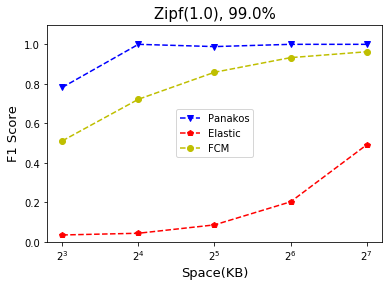

In [25]:
identifyTailItemsVsSpace(0.99, "zipf", 10**5, zipf_1)

In [33]:
def CardinalityAndEntropy(metrics = 0, streamType = "zipf", streamLength = 10**5, dataset = []):
    # metrics 0 - cardinality
    #         1 - entropy
    P_errors = []
    M_errors = []
    E_errors = []
    F_errors = []
        
    P_T = 17    
    spaces = [2**12*4/1024, 2**13*4/1024, 2**14*4/1024, 2**15*4/1024]
    insertions = dataset[:streamLength]
    s = 1.0
    for index, s in enumerate(spaces):
        s *= 1024 / 4 # conver to number of counters
        SS_eps = 1.0 / (s * PanakosComponentsSpaceRatio[0])
        bitlen = math.ceil( PanakosComponentsSpaceRatio[1] * s * 32 / 2)
        # CM uses 2 rows
        CM_eps = 2.0 / ((PanakosComponentsSpaceRatio[2] * s) * (32 / math.log2(P_T-2)))  

        P = Panakos(bitlen, SS_eps, CM_eps, P_T)
        M = MRAC(P.space())
        # in the paper it says heavy part is 25% (150/600) and lightpart is 75% (560/600) of total memory
        # in HeavyPart buket contains 8 pairs
        E = ElasticSketch(math.ceil(0.25*P.space()/8), math.ceil(0.75*P.space() * 4)) 
        
        # FCMx is the number of entires in the last layer for FCM
        # FCM uses 8 bit, 16bit and 32bit with branching factor of 8
        FCMx = int(P.space()*32.0 / (32 + 16 * 8 + 8 * 64))
        F = FCMSketch([[64*FCMx, 8],[8*FCMx, 16],[FCMx, 32]])
        
        for i in insertions:
            P.update(i)
            F.update(i)
            E.insert(i)
            M.insert(i)
            
        true_result = 0
            
        P_estimate, F_estimate, E_estimate, M_estimate = 0, 0, 0, 0
            
        if metrics == 0:
            true_result = len(set(insertions))
            P_estimate = P.cardinality()
            F_estimate = F.cardinality()
            E_estimate = E.cardinality()
            M_estimate = M.cardinality()
                
        else:
            table = collections.Counter(insertions)
            max_freq = max(table.values())
            true_vector = [0 for i in range(max_freq+1)]
            for key, val in table.items():
                true_vector[val] += 1
            pk = []
            tot = sum(true_vector)
            for i in true_vector:
                pk.append(1.0 * i / tot)
            true_result = entropy(pk)
                
            P_estimate = P.entropy()
            F_estimate = F.entropy()
            E_estimate = E.entropy()
            M_estimate = M.entropy()
            


        P_error, F_error, M_error, E_error = 0, 0, 0, 0
            
        P_error = 1.0 * abs(P_estimate - true_result) / true_result
        F_error = 1.0 * abs(F_estimate - true_result) / true_result
        M_error = 1.0 * abs(M_estimate - true_result) / true_result
        E_error = 1.0 * abs(E_estimate - true_result) / true_result
                

        P_errors.append(P_error)
        F_errors.append(F_error)
        E_errors.append(E_error)
        M_errors.append(M_error)
    
    print(spaces)
    print("P: ", P_errors)
    print("F: ", F_errors)
    print("M: ", M_errors)
    print("E: ", E_errors)
    
    title = ""
    if metrics == 0:
        title = "Cardinality "
    elif metrics == 1:
        title = "Entropy "
    
    
    if streamType == 'zipf':
            plt.title(title + "Zipf("+str(a)+")", fontsize=15)
    elif streamType == 'CAIDA':
        plt.title(title + "CAIDA", fontsize=15)
    elif streamType == "sensor":
        plt.title("SensorScope", fontsize=15)
    else:
        plt.title(title + "E-Shop", fontsize=15)
        
    plt.xlabel('Space(KB)', fontsize=13)
    
    plt.ylabel('Averaged Relative Error', fontsize=13)
        
    plt.xscale('log',basex=2)
    #plt.yscale('log',basey=10)

    plt.plot(spaces, P_errors, 'bv--', label='Panakos')
    plt.plot(spaces, M_errors, 'kd--', label='MRAC')
    plt.plot(spaces, E_errors, 'rp--', label='Elastic')
    plt.plot(spaces, F_errors, 'yo--', label='FCM')



    plt.legend(prop={'size': 10})


[16.0, 32.0, 64.0, 128.0]
P:  [0.00015984546172212916, 0.0022164472249713066, 0.000690404513610267, 0.0019110119149452912]
F:  [0.0028307086017638505, 0.007641973576319142, 0.0012781445407450045, 0.0018332396761796402]
M:  [0.009349716625780134, 0.006236899255699181, 0.002253863871115133, 0.006828829237224234]
E:  [5.626413215597496e-05, 0.005714180454972953, 0.01568760898711428, 0.004551791912318996]


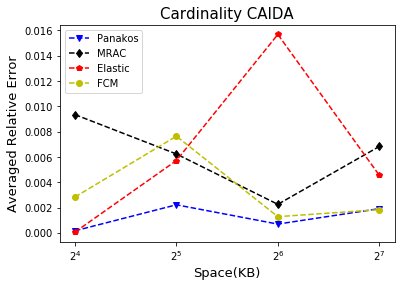

In [34]:
    CardinalityAndEntropy(0, "CAIDA", 10**5, zipf_1)

[16.0, 32.0, 64.0, 128.0]
P:  [23.251461462197547, 21.644528323275665, 20.97300735318498, 20.63320388950487]
F:  [36.26475383161772, 27.229099071870543, 23.720050159655585, 21.813026321600304]
M:  [79.84596290294918, 44.95440353330497, 30.48475632096209, 24.44696695730585]
E:  [463.60849750929646, 279.3238918138314, 144.34745591977617, 62.62189654519628]


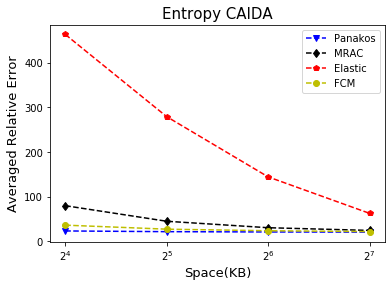

In [35]:
    CardinalityAndEntropy(1, "CAIDA", 10**5, zipf_1)

In [40]:
def FrequencyEstimation(streamType = "zipf", streamLength = 10**5, dataset = []):
    
    P_errors = []
    E_errors = []
    F_errors = []
    C_errors = []
        
    a = 1.0
    
    P_T = 17    
    spaces = [2**11*4/1024, 2**12*4/1024, 2**13*4/1024, 2**14*4/1024, 2**15*4/1024]
    insertions = dataset[:streamLength]

    for index, s in enumerate(spaces):
        s *= 1024 / 4 # conver to number of counters
        SS_eps = 1.0 / (s * PanakosComponentsSpaceRatio[0])
        bitlen = math.ceil( PanakosComponentsSpaceRatio[1] * s * 32 / 2)
        # CM uses 2 rows
        CM_eps = 2.0 / ((PanakosComponentsSpaceRatio[2] * s) * (32 / math.log2(P_T-2)))  

        P = Panakos(bitlen, SS_eps, CM_eps, P_T)
        # in the paper it says heavy part is 25% (150/600) and lightpart is 75% (560/600) of total memory
        # in HeavyPart buket contains 8 pairs
        E = ElasticSketch(math.ceil(0.25*P.space()/8), math.ceil(0.75*P.space() * 4)) 
        
        # FCMx is the number of entires in the last layer for FCM
        # FCM uses 8 bit, 16bit and 32bit with branching factor of 8
        FCMx = int(P.space()*32.0 / (32 + 16 * 8 + 8 * 64))
        F = FCMSketch([[64*FCMx, 8],[8*FCMx, 16],[FCMx, 32]])
    
        C = CocoSketch(P.space()) 
            
        for i in insertions:
            P.update(i)
            F.update(i)
            E.insert(i)
            C.insert(i)
            
        true_result = 0
            
        P_estimate, F_estimate, E_estimate, C_estimate = 0, 0, 0, 0
        P_error, F_error, E_error, C_error = 0, 0, 0, 0
            
        table = collections.Counter(insertions)
        distinct = 0
        for key, val in table.items():
            distinct +=1
            
            P_estimate = P.query(key)
            P_error += abs(P_estimate - val) / val

            F_estimate = F.query(key)
            F_error += abs(F_estimate - val)/val

            E_estimate = E.query(key)
            E_error += abs(E_estimate - val)/val

            C_estimate = C.query(key)
            C_error += abs(C_estimate - val)/val

            
        P_error /= (1.0 * distinct)
        F_error /= (1.0 * distinct)
        E_error /= (1.0 * distinct)
        C_error /= (1.0 * distinct)
                

        P_errors.append(P_error)
        F_errors.append(F_error)
        E_errors.append(E_error)
        C_errors.append(C_error)

    
    print(spaces)
    print("P: ", P_errors)
    print("F: ", F_errors)
    print("C: ", C_errors)
    print("E: ", E_errors)    
    title = ""
    
    if streamType == 'zipf':
            plt.title(title + "Zipf("+str(a)+")", fontsize=15)
    elif streamType == 'CAIDA':
        plt.title(title + "CAIDA", fontsize=15)
    elif streamType == "sensor":
        plt.title("SensorScope", fontsize=15)
    else:
        plt.title(title + "E-Shop", fontsize=15)
        
    plt.xlabel('Space(KB)', fontsize=13)
    plt.ylabel('ARE', fontsize=13)

    plt.plot(spaces, P_errors, 'bv--', label='Panakos')
    plt.plot(spaces, E_errors, 'rp--', label='Elastic')
    plt.plot(spaces, F_errors, 'yo--', label='FCM')
    plt.plot(spaces, C_errors, 'x--', color = '#FFA500', label='Coco')



    plt.legend(prop={'size': 10})

[8.0, 16.0, 32.0, 64.0, 128.0]
P:  [2.993238867688565, 0.9176540684987825, 0.3841661611127124, 0.18910598473577905, 0.09322150234539794]
F:  [3.4316971213315486, 1.3094648722269369, 0.44832584911701556, 0.16109182312283227, 0.036200735825239735]
C:  [1.8291406767544887, 1.621455211483338, 1.246876761872528, 0.6663749055674092, 0.21343129946184422]
E:  [4.900086367675104, 2.192903070805428, 0.920357171249227, 0.3672613088243724, 0.09736603921463877]


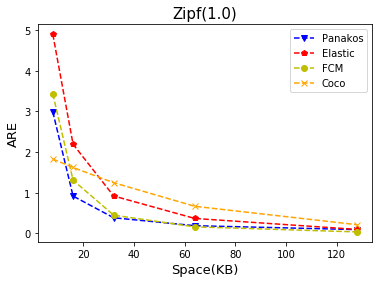

In [41]:
    FrequencyEstimation('zipf', 10**5, zipf_1)